<a href="https://colab.research.google.com/github/Y4S1-Deep-Learning/Apple-Leaves-Desease-Detection---Supervised-Learning/blob/kaushalya/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Mask RCNN**

In [1]:
!git clone https://github.com/akTwelve/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 137.72 MiB | 28.24 MiB/s, done.
Resolving deltas: 100% (570/570), done.


In [2]:
import os
import sys
os.chdir('Mask_RCNN/samples')

In [3]:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

**Install libraries**

In [4]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from Mask_RCNN.mrcnn.utils import Dataset
from matplotlib import pyplot
from Mask_RCNN.mrcnn.visualize import display_instances
from Mask_RCNN.mrcnn.utils import extract_bboxes
from Mask_RCNN.mrcnn.config import Config
from Mask_RCNN.mrcnn import utils

**Load training dataset**

In [5]:
#images_path = "dataset/images.zip"
#annotation_path = "dataset/annots.zip"

#!unzip(os.path.join("content", images_path), "/content/dataset/train/images")
!unzip "/content/dataset/train/imagesNew.zip" -d "/content/dataset/train/"
!unzip "/content/dataset/train/annotsNew.zip" -d "/content/dataset/train/"

!unzip "/content/dataset/test/imagesNew.zip" -d "/content/dataset/test/"
!unzip "/content/dataset/test/annotsNew.zip" -d "/content/dataset/test/"

Archive:  /content/dataset/train/imagesNew.zip
  inflating: /content/dataset/train/imagesNew/1.JPG  
  inflating: /content/dataset/train/imagesNew/10.JPG  
  inflating: /content/dataset/train/imagesNew/11.JPG  
  inflating: /content/dataset/train/imagesNew/12.JPG  
  inflating: /content/dataset/train/imagesNew/2.JPG  
  inflating: /content/dataset/train/imagesNew/3.JPG  
  inflating: /content/dataset/train/imagesNew/4.JPG  
  inflating: /content/dataset/train/imagesNew/5.JPG  
  inflating: /content/dataset/train/imagesNew/6.JPG  
  inflating: /content/dataset/train/imagesNew/7.JPG  
  inflating: /content/dataset/train/imagesNew/8.JPG  
  inflating: /content/dataset/train/imagesNew/9.JPG  
Archive:  /content/dataset/train/annotsNew.zip
  inflating: /content/dataset/train/annotsNew/1.xml  
  inflating: /content/dataset/train/annotsNew/10.xml  
  inflating: /content/dataset/train/annotsNew/11.xml  
  inflating: /content/dataset/train/annotsNew/12.xml  
  inflating: /content/dataset/train/

In [8]:
class AppleLeafDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define classes
        self.add_class("dataset", 1, "Black Rot")
        self.add_class("dataset", 2, "Apple Scab")
        self.add_class("dataset", 3, "Cedar Apple")

        # define data locations
        images_dir = dataset_dir + '/imagesNew/'
        annotations_dir = dataset_dir + '/annotsNew/'


		# find all images
        for filename in listdir(images_dir):
            print(filename)
			# extract image id
            image_id = filename[:-4]
			#print('IMAGE ID: ',image_id)

			# skip all images after 115 if we are building the train set
            if is_train and int(image_id) >= 250:
                continue
			# skip all images before 115 if we are building the test/val set
            if not is_train and int(image_id) < 250:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path, class_ids = [0,1,2,3])


	# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
		# load and parse the file
        tree = ElementTree.parse(filename)
		# get the root of the document
        root = tree.getroot()
		# extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text   #Add label name to the box list
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)
		# extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

	# load the masks for an image
    def load_mask(self, image_id):
		# get details of image
        info = self.image_info[image_id]
		# define box file location
        path = info['annotation']
        #return info, path


		# load XML
        boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]


            # box[4] will have the name of the class
            if (box[4] == 'Black Rot'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Black Rot'))
            elif(box[4] == 'Apple Scab'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Apple Scab'))
            elif(box[4] == 'Cedar Apple'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Cedar Apple'))

        return masks, asarray(class_ids, dtype='int32')


	# load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

6.JPG
9.JPG
7.JPG
4.JPG
10.JPG
12.JPG
8.JPG
5.JPG
2.JPG
11.JPG
3.JPG
1.JPG
Train: 12
6.JPG
9.JPG
7.JPG
4.JPG
10.JPG
12.JPG
8.JPG
5.JPG
2.JPG
11.JPG
3.JPG
1.JPG
Test: 0


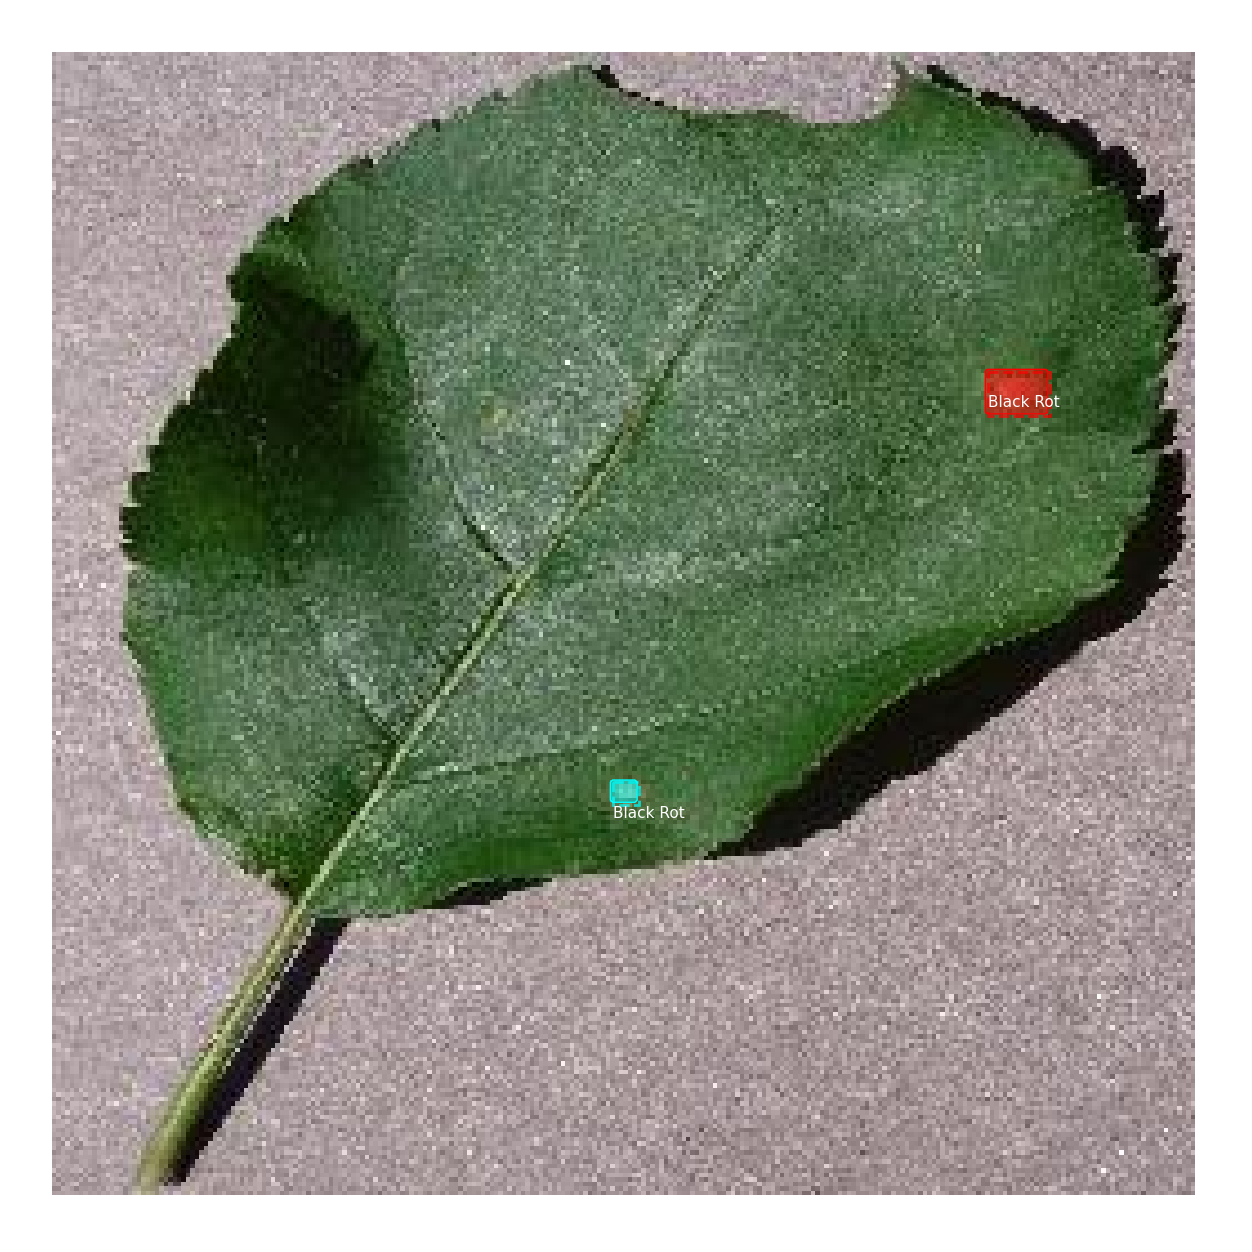

In [9]:
dataset_dir = "/content/dataset/train"
# train set
train_set = AppleLeafDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = AppleLeafDataset()
test_set.load_dataset(dataset_dir, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

import random
num=random.randint(0, len(train_set.image_ids))
# define image id
image_id = num
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

**Training**

In [16]:
# define a configuration for the model
class AppleLeavesConfig(Config):
	# define the name of the configuration
	NAME = "object"

	NUM_CLASSES = 1 + 3
	# number of training steps per epoch
	STEPS_PER_EPOCH = 2

	#IMAGES_PER_GPU = 2

# prepare config
config = AppleLeavesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [11]:
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [12]:
import keras
#print(keras.__version__)

In [ ]:
!pip install --upgrade keras    #upgrade keras

In [13]:
from Mask_RCNN.mrcnn.model import MaskRCNN

from keras import models
model = models.Sequential()

In [17]:
# define the model
model = MaskRCNN(mode='training', model_dir="/content/logs", config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights("/content/mask_rcnn_coco.h5", by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=4, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/object20230928T0624/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistri

KeyboardInterrupt: ignored

In [ ]:
from matplotlib.patches import Rectangle

**Prediction**

In [ ]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "objects"

	NUM_CLASSES = 1 + 3

	GPU_COUNT = 1
	IMAGES_PER_GPU = 2

In [ ]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
# load model weights
model.load_weights('/content/logs/object20230928T0004/mask_rcnn_object_{epoch:04d}.h5', by_name=True)

In [ ]:
import skimage

leaf_img = skimage.io.imread("/content/dataset/test_new/applescab_1.jpg")
detected = model.detect([leaf_img])[0]

pyplot.imshow(leaf_img)
ax = pyplot.gca()
class_names = ['Black Rot', 'Apple Scab', 'Cedar Apple']
class_id_counter=1
for box in detected['rois']:
    detected_class_id = detected['class_ids'][class_id_counter-1]
    y1, x1, y2, x2 = box
    #calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    #create the shape
    ax.annotate(class_names[detected_class_id-1], (x1, y1), color='black', weight='bold', fontsize=10, ha='center', va='center')
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
#draw the box
    ax.add_patch(rect)
    class_id_counter+=1
#show the figure
pyplot.show()